In [1]:
import jax
import jax.numpy as jnp  # JAX NumPy
import optax  # Optimizers
import equinox as eqx  # Equinox

from flowMC.resource.model.common import MLP
from flowMC.resource.model.flowmatching.base import Solver, Path, CondOTScheduler, FlowMatchingModel
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt


In [10]:
# Optimization parameters
num_epochs = 1000
batch_size = 10000
learning_rate = 1e-3
momentum = 0.9
n_samples = 10000
seed = 0

In [11]:
solver = Solver(MLP([3,64, 64,2], jax.random.PRNGKey(0), activation=jax.nn.swish))
path = Path(CondOTScheduler())
model = FlowMatchingModel(solver, path)

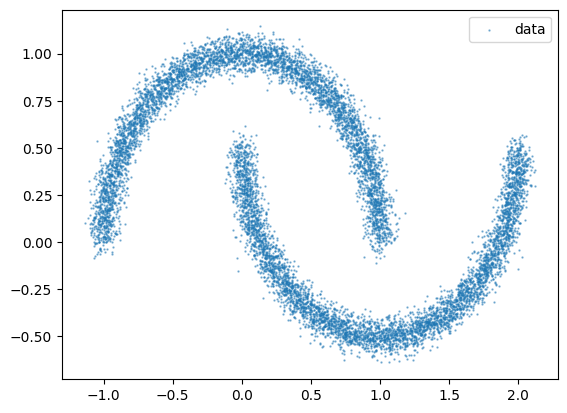

In [12]:
data = jnp.array(make_moons(n_samples, noise=0.05)[0])

plt.scatter(data[:, 0], data[:, 1], s=0.5, alpha=0.5, label="data")
plt.legend()

In [13]:

key = jax.random.PRNGKey(seed)

key, subkey = jax.random.split(key)
x0 = jax.random.normal(subkey, (data.shape[0], 2))  # Initial points
key, subkey = jax.random.split(key)
t = jax.random.uniform(subkey, (data.shape[0], 1), minval=0.0, maxval=1.0)  # Random time points

optim = optax.adam(learning_rate)
state = optim.init(eqx.filter(model, eqx.is_array))
key, subkey = jax.random.split(key)
key, trained_model, state, loss = model.train(
    key, (x0, data, t), optim, state, num_epochs, batch_size, verbose=True
)

Training NF:   0%|          | 0/1000 [00:00<?, ?it/s]

Training NF, current loss: 1.711:   0%|          | 0/1000 [00:00<?, ?it/s]

Compiling training step


Training NF, current loss: 1.033: 100%|██████████| 1000/1000 [00:04<00:00, 247.01it/s]


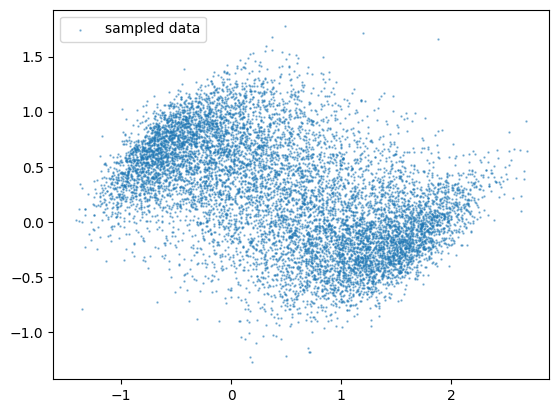

In [14]:
sampled_data = trained_model.sample(key, 10000, dt=0.1)
plt.scatter(sampled_data[:, 0], sampled_data[:, 1], s=0.5, alpha=0.5, label="sampled data")
plt.legend()
plt.show()

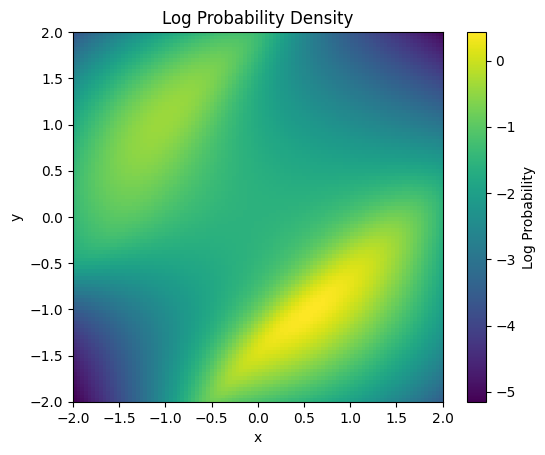

In [15]:
grid = jnp.mgrid[-2:2:100j, -2:2:100j]
grid = grid.reshape(2, -1).T  # Reshape to (10000, 2)
log_prob = eqx.filter_vmap(trained_model.log_prob, in_axes=(0,))(grid)
plt.imshow(log_prob.reshape(100, 100), extent=(-2, 2, -2, 2), origin='lower', cmap='viridis')
plt.colorbar(label='Log Probability')
plt.title('Log Probability Density')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [8]:
trained_model.log_prob(data[0])

Array([-1.5568687], dtype=float32)

In [9]:
from jax.scipy.stats.multivariate_normal import logpdf
logpdf(data, mean=jnp.zeros(2), cov=jnp.eye(2))

Array([-2.4006608, -3.9531667, -2.4247491, ..., -2.3087032, -2.3414826,
       -2.2881417], dtype=float32)